In [2]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.figure_factory as ff
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
# add to dependencies
!pip install geopandas==0.3.0
!pip install pyshp==1.2.10
!pip install shapely==1.6.3
!conda install -c plotly plotly-geo
!conda install plotly

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.



### NYTimes Data

In [3]:
data_nytimes = pd.read_csv('../data/nytimes_covid19_data/20200405_us-counties.csv')
data_nytimes.tail()

,date,county,state,fips,cases,deaths
33246,2020-04-04,Sublette,Wyoming,56035.0,1,0
33247,2020-04-04,Sweetwater,Wyoming,56037.0,4,0
33248,2020-04-04,Teton,Wyoming,56039.0,36,0
33249,2020-04-04,Uinta,Wyoming,56041.0,2,0
33250,2020-04-04,Washakie,Wyoming,56043.0,2,0


In [4]:
data_nytimes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33251 entries, 0 to 33250
Data columns (total 6 columns):
date      33251 non-null object
county    33251 non-null object
state     33251 non-null object
fips      32764 non-null float64
cases     33251 non-null int64
deaths    33251 non-null int64
dtypes: float64(1), int64(2), object(3)
memory usage: 1.5+ MB


In [5]:
data_nytimes['date'] = pd.to_datetime(data_nytimes['date'])
data_nytimes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33251 entries, 0 to 33250
Data columns (total 6 columns):
date      33251 non-null datetime64[ns]
county    33251 non-null object
state     33251 non-null object
fips      32764 non-null float64
cases     33251 non-null int64
deaths    33251 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 1.5+ MB


### Geographic Distribution

In [6]:
# drop NA in fips
data_nytimes = data_nytimes.dropna()

#get data from recent date

recent_date = data_nytimes.date.max()
data_nytimes_recent = data_nytimes[data_nytimes['date']==recent_date]

data_nytimes_recent.describe()

,fips,cases,deaths
count,2376.000000,2376.000000,2376.000000
mean,29830.944865,101.463805,2.458333
std,15454.731116,606.406267,15.261839
min,1001.000000,0.000000,0.000000
25%,18022.500000,2.000000,0.000000
50%,29014.000000,7.000000,0.000000
75%,45011.500000,28.000000,1.000000
max,56043.000000,13346.000000,396.000000


In [7]:
# plot geographic plots
colorscale = ["#ebf3fb","#deebf7","#d2e3f3","#c6dbef","#b3d2e9","#9ecae1",
              "#85bcdb","#6baed6","#57a0ce","#4292c6","#3082be","#2171b5","#1361a9",
              "#08519c","#0b4083","#08306b"]
endpts = [1,10,50,100,500,1000,2000,5000,10000,15000,]
fips = data_nytimes_recent.fips.tolist()
values = data_nytimes_recent['cases'].tolist()

fig = ff.create_choropleth(
    fips=fips, values=values,
    binning_endpoints=endpts,
    colorscale=colorscale,
    show_state_data=False,
    show_hover=True, centroid_marker={'opacity': 0},
    asp=2.9, title='US Confirmed Cases by County',
    legend_title='number of cases'
)

fig.layout.template = None
fig.show()

ValueError: 
The create_choropleth figure factory requires the plotly-geo package.
Install using pip with:

$ pip install plotly-geo

Or, install using conda with

$ conda install -c plotly plotly-geo


In [8]:
# plot geographic plots
colorscale = ["#ebf3fb","#deebf7","#d2e3f3","#c6dbef","#b3d2e9","#9ecae1",
              "#85bcdb","#6baed6","#57a0ce","#4292c6","#3082be","#2171b5","#1361a9",
              "#08519c","#0b4083","#08306b"]
endpts = [1,5,10,20,50,100,150,200,250,300,350,400]
fips = data_nytimes_recent.fips.tolist()
values = data_nytimes_recent['deaths'].tolist()

fig = ff.create_choropleth(
    fips=fips, values=values,
    binning_endpoints=endpts,
    colorscale=colorscale,
    show_state_data=False,
    show_hover=True, centroid_marker={'opacity': 0},
    asp=2.9, title='US Deaths by County',
    legend_title='number of deaths'
)

fig.layout.template = None
fig.show()

ValueError: 
The create_choropleth figure factory requires the plotly-geo package.
Install using pip with:

$ pip install plotly-geo

Or, install using conda with

$ conda install -c plotly plotly-geo


### Time Series

In [9]:
# concate county and state since some counties have the same name
data_nytimes['county_state'] = data_nytimes.county + ', ' + data_nytimes.state
data_nytimes.head()

,date,county,state,fips,cases,deaths,county_state
0,2020-01-21,Snohomish,Washington,53061.0,1,0,"Snohomish, Washington"
1,2020-01-22,Snohomish,Washington,53061.0,1,0,"Snohomish, Washington"
2,2020-01-23,Snohomish,Washington,53061.0,1,0,"Snohomish, Washington"
3,2020-01-24,Cook,Illinois,17031.0,1,0,"Cook, Illinois"
4,2020-01-24,Snohomish,Washington,53061.0,1,0,"Snohomish, Washington"


In [10]:
# sort data for shift later and calculate daily new cases and daily new deaths
df = data_nytimes.sort_values(by=['county_state', 'date'])

df['yesterday_cases'] = df.groupby(['county_state'])['cases'].shift(1)
df['yesterday_cases'].fillna(value = 0, inplace = True)
df['new_cases'] = df['cases'] - df['yesterday_cases']

df['yesterday_deaths'] = df.groupby(['county_state'])['deaths'].shift(1)
df['yesterday_deaths'].fillna(value = 0, inplace = True)
df['new_deaths'] = df['deaths'] - df['yesterday_deaths']
df.head()

,date,county,state,fips,cases,deaths,county_state,yesterday_cases,new_cases,yesterday_deaths,new_deaths
5000,2020-03-19,Abbeville,South Carolina,45001.0,1,0,"Abbeville, South Carolina",0.0,1.0,0.0,0.0
5873,2020-03-20,Abbeville,South Carolina,45001.0,1,0,"Abbeville, South Carolina",1.0,0.0,0.0,0.0
6877,2020-03-21,Abbeville,South Carolina,45001.0,1,0,"Abbeville, South Carolina",1.0,0.0,0.0,0.0
7997,2020-03-22,Abbeville,South Carolina,45001.0,1,0,"Abbeville, South Carolina",1.0,0.0,0.0,0.0
9209,2020-03-23,Abbeville,South Carolina,45001.0,1,0,"Abbeville, South Carolina",1.0,0.0,0.0,0.0


In [11]:
# time series data
df_total = df.groupby('date').sum()
df_total.head()

,fips,cases,deaths,yesterday_cases,new_cases,yesterday_deaths,new_deaths
date,,,,,,,
2020-01-21,53061.0,1,0,0.0,1.0,0.0,0.0
2020-01-22,53061.0,1,0,1.0,0.0,0.0,0.0
2020-01-23,53061.0,1,0,1.0,0.0,0.0,0.0
2020-01-24,70092.0,2,0,1.0,1.0,0.0,0.0
2020-01-25,76151.0,3,0,2.0,1.0,0.0,0.0


In [12]:
# Mortality rate
df_total['mortality'] = df_total['deaths']/df_total['cases']
df_total.head()

,fips,cases,deaths,yesterday_cases,new_cases,yesterday_deaths,new_deaths,mortality
date,,,,,,,,
2020-01-21,53061.0,1,0,0.0,1.0,0.0,0.0,0.0
2020-01-22,53061.0,1,0,1.0,0.0,0.0,0.0,0.0
2020-01-23,53061.0,1,0,1.0,0.0,0.0,0.0,0.0
2020-01-24,70092.0,2,0,1.0,1.0,0.0,0.0,0.0
2020-01-25,76151.0,3,0,2.0,1.0,0.0,0.0,0.0


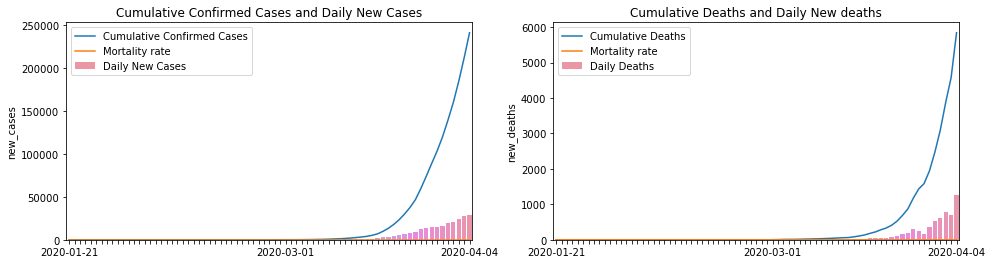

In [13]:
# plot overall cumulative cases and daily new case

fig, axes = plt.subplots(1,2, figsize=(16,4))
# confirmed cases
sns.lineplot(range(len(df_total.index)), df_total.cases, ax = axes[0], label = 'Cumulative Confirmed Cases')
sns.lineplot(range(len(df_total.index)), df_total.mortality, ax = axes[0], label = 'Mortality rate')
sns.barplot(list(range(len(df_total.index))), df_total.new_cases, ax = axes[0], label = 'Daily New Cases')
axes[0].set_title('Cumulative Confirmed Cases and Daily New Cases')


# labels for xticks
labels = ['2020-01-21']
labels += len(pd.date_range('2020-01-22', '2020-02-29')) * [''] 
labels += ['2020-03-01']
labels += len(pd.date_range('2020-03-02', '2020-04-03')) * [''] 
labels += ['2020-04-04']
axes[0].set_xticklabels(labels)
axes[0].legend()
#axes[0].set_yscale('log')

# death
sns.lineplot(range(len(df_total.index)), df_total.deaths, ax = axes[1], label = 'Cumulative Deaths')
sns.lineplot(range(len(df_total.index)), df_total.mortality, ax = axes[1], label = 'Mortality rate')
sns.barplot(list(range(len(df_total.index))), df_total.new_deaths, ax = axes[1], label = 'Daily Deaths')
axes[1].set_title('Cumulative Deaths and Daily New deaths')
axes[1].set_xticklabels(labels)
axes[1].legend();

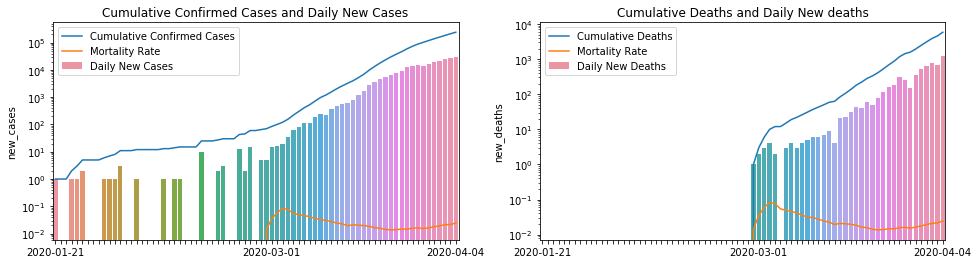

In [14]:
# log scale on y-axis

fig, axes = plt.subplots(1,2, figsize=(16,4))
# confirmed cases
sns.lineplot(range(len(df_total.index)), df_total.cases, ax = axes[0], label = 'Cumulative Confirmed Cases')
sns.lineplot(range(len(df_total.index)), df_total.mortality, ax = axes[0], label = 'Mortality Rate')
sns.barplot(list(range(len(df_total.index))), df_total.new_cases, ax = axes[0], label = 'Daily New Cases')
axes[0].set_title('Cumulative Confirmed Cases and Daily New Cases')

# labels for xticks
labels = ['2020-01-21']
labels += len(pd.date_range('2020-01-22', '2020-02-29')) * [''] 
labels += ['2020-03-01']
labels += len(pd.date_range('2020-03-02', '2020-04-03')) * [''] 
labels += ['2020-04-04']
axes[0].set_xticklabels(labels)
#axes[0].set_ylim(bottom=0.1)
axes[0].set_yscale('log')
axes[0].legend()

# death
sns.lineplot(range(len(df_total.index)), df_total.deaths, ax = axes[1], label = 'Cumulative Deaths')
sns.lineplot(range(len(df_total.index)), df_total.mortality, ax = axes[1], label = 'Mortality Rate')
sns.barplot(list(range(len(df_total.index))), df_total.new_deaths, ax = axes[1], label = 'Daily New Deaths')
axes[1].set_title('Cumulative Deaths and Daily New deaths')
axes[1].set_xticklabels(labels)

axes[1].set_yscale('log')
axes[1].legend();

### County Level Data

In [70]:
# find top n counties with largest cumulative cases
top_n = 10

# drop logs where county is Unknown
data_nytimes = data_nytimes[data_nytimes.county != 'Unknown']
df = data_nytimes
counties = data_nytimes[data_nytimes.date == recent_date].groupby('county_state').sum().cases.nlargest(top_n).index.tolist()

dfr = data_nytimes[data_nytimes.date == recent_date]

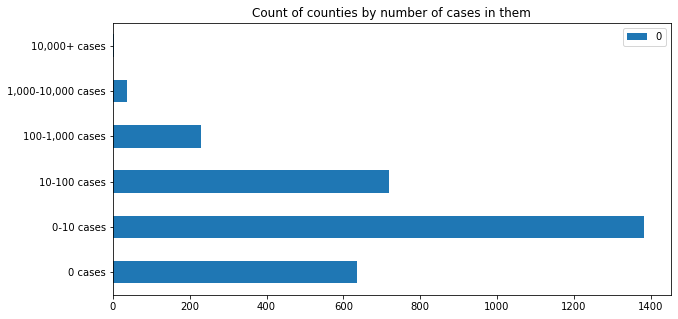

In [82]:
#plotting the count of counties with certain number of cases

limits = [float("-inf"),0,10,100,1000,10000, float("inf")]
casecounts = []
for i in range(len(limits)-1):
    casecounts.append(len(dfr[(dfr['cases'] > limits[i]) & (dfr['cases'] <= limits[i+1])]))

#we don't really need this below
counties0 = dfr[dfr['cases'] == 0]
counties10 = dfr[(dfr['cases'] > 0) & (dfr['cases'] <= 10)]
counties100 = dfr[(dfr['cases'] > 10) & (dfr['cases'] <= 100)]
counties1000 = dfr[(dfr['cases'] > 100) & (dfr['cases'] <= 1000)]
counties10000 = dfr[(dfr['cases'] > 1000) & (dfr['cases'] <= 10000)]
counties10000m = dfr[(dfr['cases'] > 10000)]


limits2 = ['0 cases','0-10 cases','10-100 cases','100-1,000 cases','1,000-10,000 cases', '10,000+ cases']
casecountsdf = pd.DataFrame(casecounts, index = limits2)
total_counties = 3007 #this is the total number of counties in the US
n_counties_0 = 3007 - sum(list(casecountsdf[0])) 
casecountsdf[0][0] = casecountsdf[0][0] + n_counties_0 #we assume that counties without data have zero cases

ax = casecountsdf.plot.barh(figsize= (10,5))
ax.set_title('Count of counties by number of cases in them');

In [117]:
df10 = df[df.cases>=10]
mindate = df10.groupby('county_state').date.min()
mindatedf = pd.DataFrame(mindate)
mindatedf['date10'] = mindatedf['date']
mindatedf = mindatedf.drop(axis = 1, labels = 'date')

df10 = df10.merge(mindatedf, how = 'left', on = 'county_state')
df10['days10'] = (df10['date'] - df10['date10']).astype('timedelta64[D]')
df10

,date,county,state,fips,cases,deaths,county_state,date10,days10
0,2020-02-17,Douglas,Nebraska,31055.0,10,0,"Douglas, Nebraska",2020-02-17,0.0
1,2020-02-18,Douglas,Nebraska,31055.0,10,0,"Douglas, Nebraska",2020-02-17,1.0
2,2020-02-19,Douglas,Nebraska,31055.0,10,0,"Douglas, Nebraska",2020-02-17,2.0
3,2020-02-20,Douglas,Nebraska,31055.0,11,0,"Douglas, Nebraska",2020-02-17,3.0
4,2020-02-21,Douglas,Nebraska,31055.0,11,0,"Douglas, Nebraska",2020-02-17,4.0
...,...,...,...,...,...,...,...,...,...
10251,2020-04-04,Fremont,Wyoming,56013.0,36,0,"Fremont, Wyoming",2020-03-22,13.0
10252,2020-04-04,Laramie,Wyoming,56021.0,42,0,"Laramie, Wyoming",2020-03-25,10.0
10253,2020-04-04,Natrona,Wyoming,56025.0,23,0,"Natrona, Wyoming",2020-03-31,4.0
10254,2020-04-04,Sheridan,Wyoming,56033.0,11,0,"Sheridan, Wyoming",2020-03-31,4.0


In [16]:
counties

['Nassau, New York',
 'Westchester, New York',
 'Suffolk, New York',
 'Cook, Illinois',
 'Wayne, Michigan',
 'Bergen, New Jersey',
 'Los Angeles, California',
 'Rockland, New York',
 'Orleans, Louisiana',
 'Miami-Dade, Florida']

In [52]:
data_nytimes[data_nytimes.date == recent_date].sort_values('cases', ascending = False)

,date,county,state,fips,cases,deaths,county_state
32267,2020-04-04,Nassau,New York,36059.0,13346,396,"Nassau, New York"
32298,2020-04-04,Westchester,New York,36119.0,13080,197,"Westchester, New York"
32289,2020-04-04,Suffolk,New York,36103.0,12328,175,"Suffolk, New York"
31375,2020-04-04,Cook,Illinois,17031.0,7439,167,"Cook, Illinois"
31903,2020-04-04,Wayne,Michigan,26163.0,6762,252,"Wayne, Michigan"
...,...,...,...,...,...,...,...
32524,2020-04-04,McCurtain,Oklahoma,40089.0,1,0,"McCurtain, Oklahoma"
32261,2020-04-04,Kings,New York,36047.0,0,0,"Kings, New York"
32280,2020-04-04,Richmond,New York,36085.0,0,0,"Richmond, New York"
32240,2020-04-04,Bronx,New York,36005.0,0,0,"Bronx, New York"


In [21]:
data = data_nytimes[data_nytimes['county_state'].isin(counties)]
data.tail()

,date,county,state,fips,cases,deaths,county_state
32193,2020-04-04,Bergen,New Jersey,34003.0,5760,179,"Bergen, New Jersey"
32267,2020-04-04,Nassau,New York,36059.0,13346,396,"Nassau, New York"
32281,2020-04-04,Rockland,New York,36087.0,4872,69,"Rockland, New York"
32289,2020-04-04,Suffolk,New York,36103.0,12328,175,"Suffolk, New York"
32298,2020-04-04,Westchester,New York,36119.0,13080,197,"Westchester, New York"


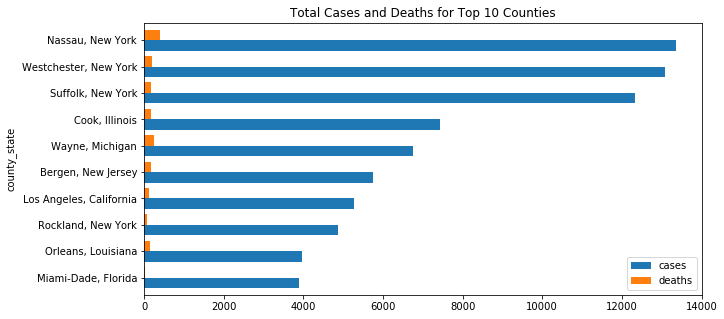

In [125]:
# barplot
data_by_county = data[data.date == recent_date].sort_values('cases', ascending = True)[['cases','deaths','county_state']]
data_by_county = data_by_county.set_index('county_state')
ax = data_by_county.plot.barh(figsize= (10,5),width=0.8)
ax.set_title('Total Cases and Deaths for Top 10 Counties');

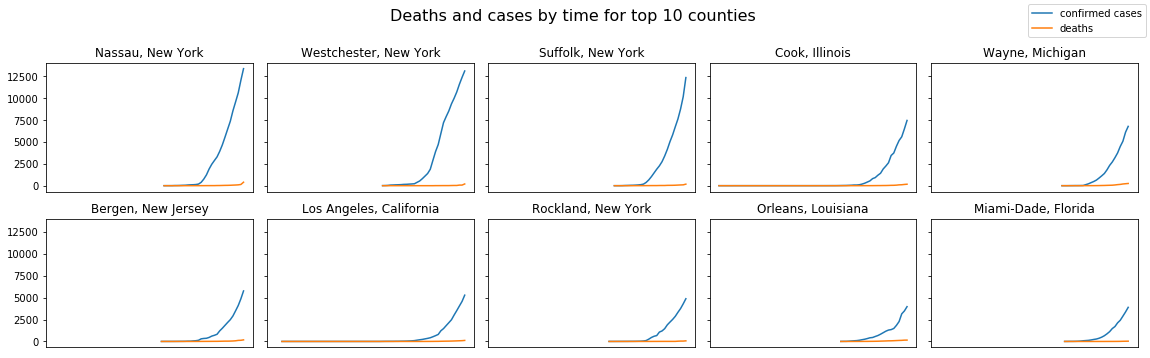

In [24]:
# initial plot
fig, axes = plt.subplots(2,5, figsize = (16,5), sharex=True, sharey=True, subplot_kw={ 'xticks': []})
#fig, axes = plt.subplots(2,5, figsize = (16,4), sharex=True, sharey=True)



for county, ax in zip(counties,axes.flat):
    data_per_county = data[data['county_state'] == county]
    ax.plot(data_per_county.date, data_per_county.cases, label = 'confirmed cases')
    ax.plot(data_per_county.date, data_per_county.deaths, label = 'deaths')
    ax.set_title(county)


handles, labels = ax.get_legend_handles_labels()
# labels for xticks


fig.legend(handles, labels, loc='middle right');
fig.suptitle('Deaths and cases by time for top 10 counties', size = 16);
fig.tight_layout()
fig.subplots_adjust(top=0.83);

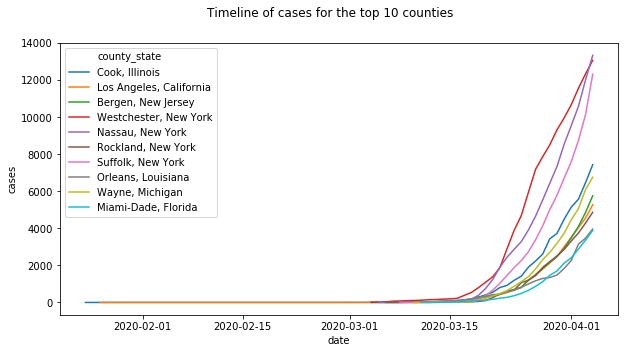

In [25]:
fig, ax = plt.subplots(figsize = (10,5))
#ax.plot(data_per_county.date, data_per_county.cases)
sns.lineplot(data=data, x='date', y='cases', hue='county_state');
fig.suptitle('Timeline of cases for the top 10 counties');

In [26]:
# data only after 2020-03-01
data_halftime = data[(data['date'] > '2020-03-01')]


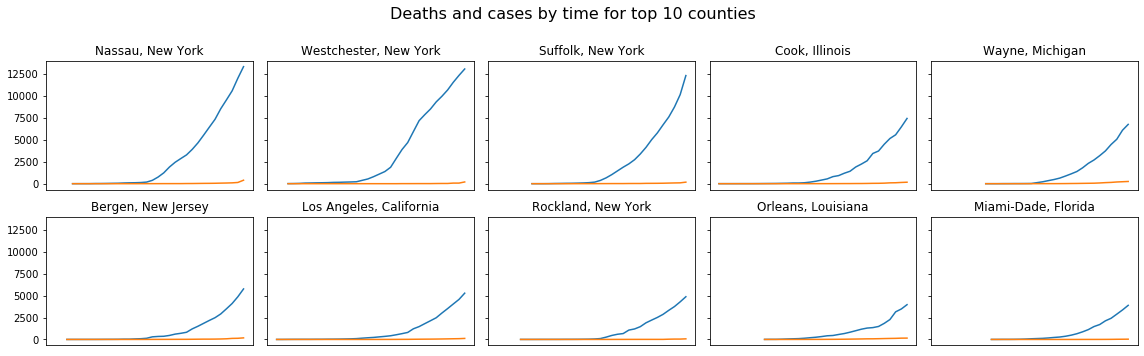

In [27]:
fig, axes = plt.subplots(2,5, figsize = (16,5), sharex=True, sharey=True, subplot_kw={ 'xticks': []})

for county, ax in zip(counties,axes.flat):
    data_per_county = data_halftime [data_halftime ['county_state'] == county]
    ax.plot(data_per_county.date, data_per_county.cases)
    ax.plot(data_per_county.date, data_per_county.deaths)
    ax.set_title(county)
    
    
fig.suptitle('Deaths and cases by time for top 10 counties', size = 16);
fig.tight_layout()
fig.subplots_adjust(top=0.83);

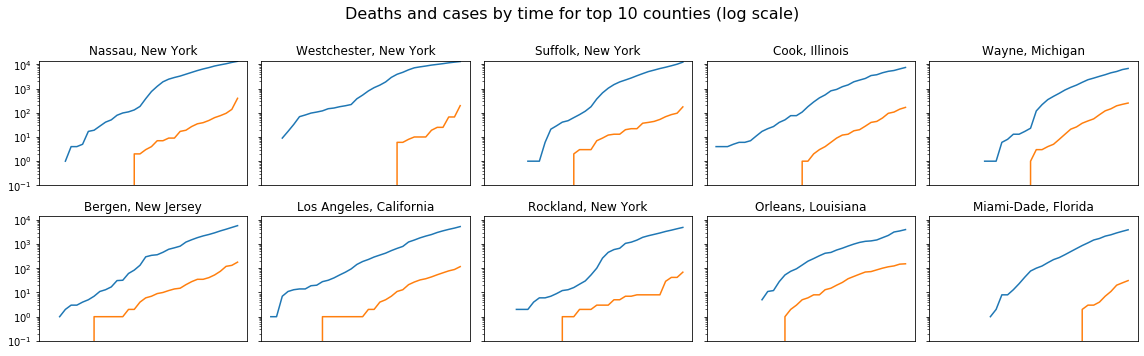

In [28]:
# log y-axis
fig, axes = plt.subplots(2,5, figsize = (16,5), sharex=True, sharey=True, subplot_kw={ 'xticks': []})

for county, ax in zip(counties,axes.flat):
    data_per_county = data_halftime [data_halftime ['county_state'] == county]
    ax.plot(data_per_county.date, data_per_county.cases)
    ax.plot(data_per_county.date, data_per_county.deaths)
    ax.set_title(county)
    ax.set_ylim(bottom=0.1)
    ax.set_yscale('log')
    
fig.suptitle('Deaths and cases by time for top 10 counties (log scale)', size = 16);
fig.tight_layout()
fig.subplots_adjust(top=0.83);

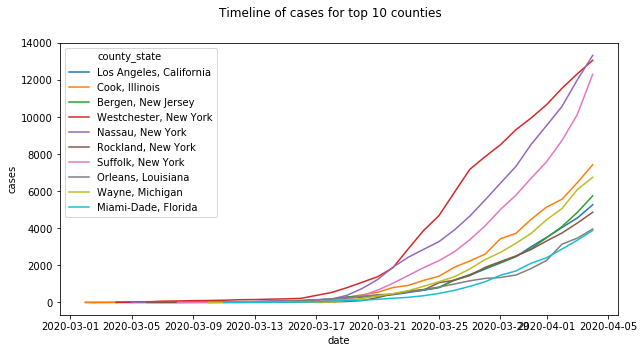

In [29]:
fig, ax = plt.subplots(figsize = (10,5));
#ax.plot(data_per_county.date, data_per_county.cases)
sns.lineplot(data=data_halftime, x='date', y='cases', hue='county_state');

fig.suptitle('Timeline of cases for top 10 counties');

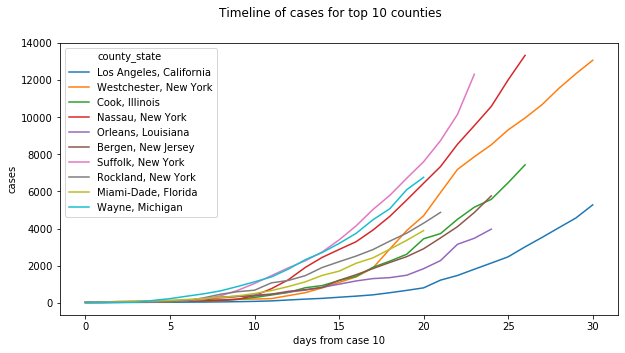

In [122]:
fig, ax = plt.subplots(figsize = (10,5));
#ax.plot(data_per_county.date, data_per_county.cases)
sns.lineplot(data=df10[df10['county_state'].isin(counties)], x='days10', y='cases', hue='county_state');

fig.suptitle('Timeline of cases for top 10 counties');
ax.set_xlabel('days from case 10')
plt.xscale('linear')

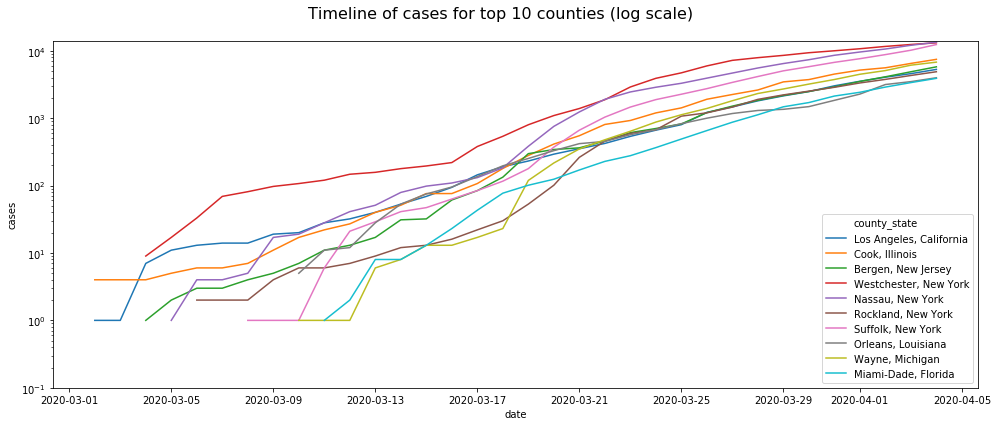

In [30]:
fig, ax = plt.subplots(figsize = (14,6))
#ax.plot(data_per_county.date, data_per_county.cases)
sns.lineplot(data=data_halftime, x='date', y='cases', hue='county_state')
ax.set_ylim(bottom=0.1)
ax.set_yscale('log');

fig.suptitle('Timeline of cases for top 10 counties (log scale)', size = 16);
fig.tight_layout()
fig.subplots_adjust(top=0.90);

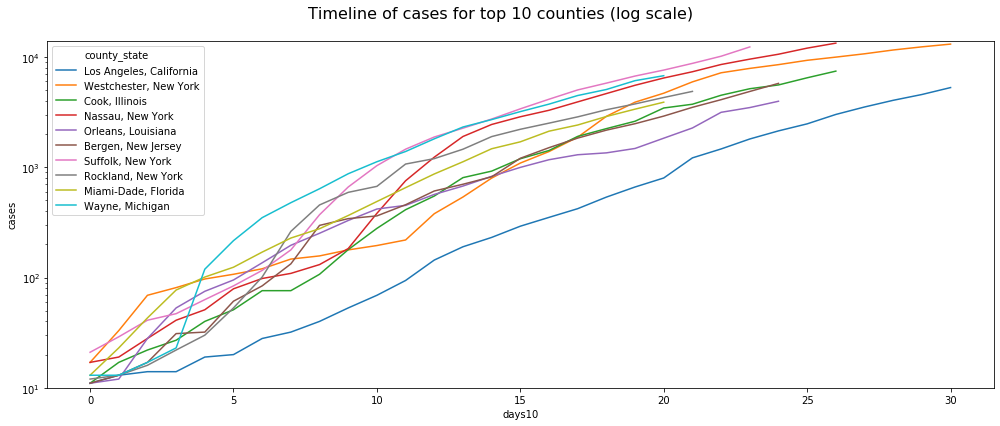

In [124]:
fig, ax = plt.subplots(figsize = (14,6))
#ax.plot(data_per_county.date, data_per_county.cases)
sns.lineplot(data=df10[df10['county_state'].isin(counties)], x='days10', y='cases', hue='county_state')
ax.set_ylim(bottom=10)
ax.set_yscale('log');

fig.suptitle('Timeline of cases for top 10 counties (log scale)', size = 16);
fig.tight_layout()
fig.subplots_adjust(top=0.90);

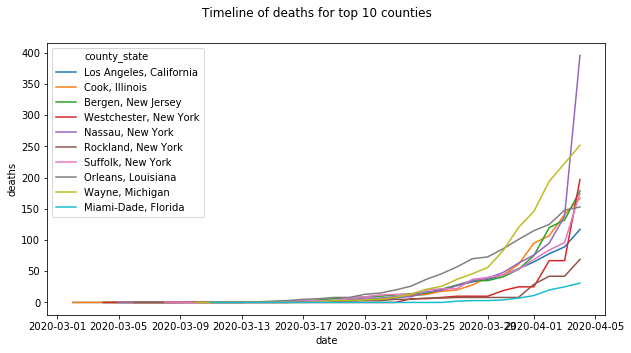

In [31]:
fig, ax = plt.subplots(figsize = (10,5));
#ax.plot(data_per_county.date, data_per_county.cases)
sns.lineplot(data=data_halftime, x='date', y='deaths', hue='county_state');

fig.suptitle('Timeline of deaths for top 10 counties');

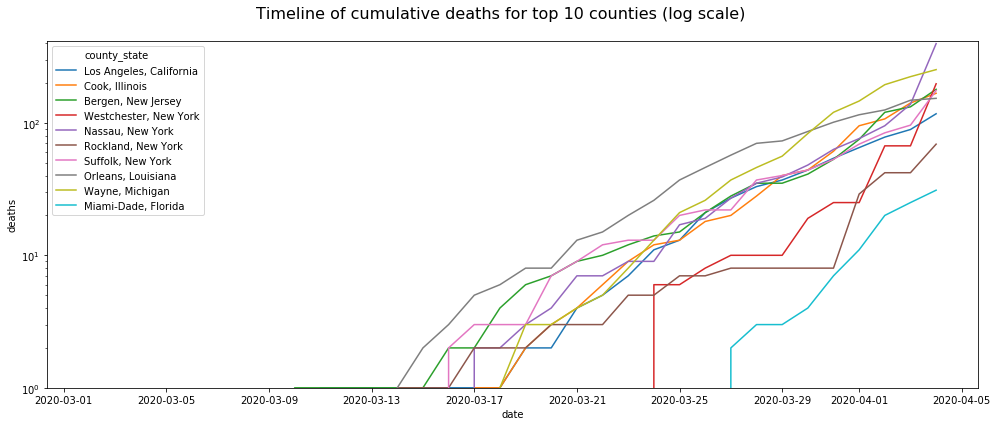

In [32]:
fig, ax = plt.subplots(figsize = (14,6))
#ax.plot(data_per_county.date, data_per_county.cases)
sns.lineplot(data=data_halftime, x='date', y='deaths', hue='county_state')
ax.set_ylim(bottom=1)
ax.set_yscale('log');

fig.suptitle('Timeline of cumulative deaths for top 10 counties (log scale)', size = 16);
fig.tight_layout()
fig.subplots_adjust(top=0.90);

We can see that most counties have a very similar slope for deaths, with the exception

### JHU Data

In [33]:
data_jhu = pd.read_csv('../data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv')
data_jhu.head()

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,...,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20
0,16,AS,ASM,16,60.0,NaN,American Samoa,US,-14.2710,-170.1320,...,0,0,0,0,0,0,0,0,0,0
1,316,GU,GUM,316,66.0,NaN,Guam,US,13.4443,144.7937,...,51,55,56,58,69,77,82,84,93,112
2,580,MP,MNP,580,69.0,NaN,Northern Mariana Islands,US,15.0979,145.6739,...,0,0,0,0,2,6,6,6,6,6
3,630,PR,PRI,630,72.0,NaN,Puerto Rico,US,18.2208,-66.5901,...,79,100,127,174,239,286,316,316,452,475
4,850,VI,VIR,850,78.0,NaN,Virgin Islands,US,18.3358,-64.8963,...,19,22,0,0,30,30,30,37,40,42


In [34]:
data_jhu.shape

(3253, 86)

In [35]:
# top 10 counties with largest confirmed cases on 4/5/20
top10_index = data_jhu['4/5/20'].nlargest(10).index.tolist()

In [36]:
data_top10 = data_jhu.iloc[top10_index]
data_top10

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,...,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20
1863,84036061,US,USA,840,36061.0,New York,New York,US,40.767273,-73.971526,...,25573,29776,33768,37453,43119,47439,51809,57159,63306,67551
1862,84036059,US,USA,840,36059.0,Nassau,New York,US,40.740665,-73.589419,...,4657,5537,6445,7344,8544,9554,10587,12024,13346,14398
1892,84036119,US,USA,840,36119.0,Westchester,New York,US,41.162784,-73.757417,...,7187,7875,8519,9326,9967,10683,11567,12351,13081,13723
1884,84036103,US,USA,840,36103.0,Suffolk,New York,US,40.883201,-72.801217,...,3385,4138,5023,5791,6713,7605,8746,10154,11370,13129
615,84017031,US,USA,840,17031.0,Cook,Illinois,US,41.841448,-87.816588,...,2239,2613,3445,3727,4496,5152,5575,6111,7439,8034
1317,84026163,US,USA,840,26163.0,Wayne,Michigan,US,42.280984,-83.281255,...,1810,2316,2704,3195,3735,4470,5069,6096,6762,7518
1780,84034003,US,USA,840,34003.0,Bergen,New Jersey,US,40.960109,-74.071643,...,1505,1838,2169,2482,2909,3494,4099,4866,5760,6187
209,84006037,US,USA,840,6037.0,Los Angeles,California,US,34.308284,-118.228241,...,1465,1465,1829,2474,3019,3518,4045,4566,4605,5955
1876,84036087,US,USA,840,36087.0,Rockland,New York,US,41.150279,-74.025605,...,1457,1896,2209,2511,2863,3321,3751,4289,4872,5326
367,84012086,US,USA,840,12086.0,Miami-Dade,Florida,US,25.611236,-80.551706,...,763,1003,1192,1632,2123,2202,2886,3364,3890,4146


In [37]:
# drop unnecessary columns
data_top10_cases = data_top10.drop(['UID','iso2','iso3','code3','FIPS','Country_Region','Lat','Long_','Combined_Key'], axis = 1)

# add new column with combined county and state
data_top10_cases['county_state'] = data_top10_cases.Admin2 + ', ' + data_top10_cases.Province_State

data_top10_cases = data_top10_cases.drop(['Admin2','Province_State'],axis=1)
data_top10_cases.head()

#data_top10.pivot(columns = 'Admin2')

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,county_state
1863,0,0,0,0,0,0,0,0,0,0,...,29776,33768,37453,43119,47439,51809,57159,63306,67551,"New York, New York"
1862,0,0,0,0,0,0,0,0,0,0,...,5537,6445,7344,8544,9554,10587,12024,13346,14398,"Nassau, New York"
1892,0,0,0,0,0,0,0,0,0,0,...,7875,8519,9326,9967,10683,11567,12351,13081,13723,"Westchester, New York"
1884,0,0,0,0,0,0,0,0,0,0,...,4138,5023,5791,6713,7605,8746,10154,11370,13129,"Suffolk, New York"
615,0,0,1,1,1,1,1,1,1,2,...,2613,3445,3727,4496,5152,5575,6111,7439,8034,"Cook, Illinois"


In [38]:
# reshape data
d = data_top10_cases.melt(id_vars=['county_state'], 
        var_name="date")
        #value_name="Value")
d.tail()

,county_state,date,value
745,"Wayne, Michigan",4/5/20,7518
746,"Bergen, New Jersey",4/5/20,6187
747,"Los Angeles, California",4/5/20,5955
748,"Rockland, New York",4/5/20,5326
749,"Miami-Dade, Florida",4/5/20,4146
